# **Home Credit Default Risk Prediction** <br>
 the challenge is to predict the likelihood of clients defaulting on loan repayments. Home Credit provides loans to people with little or no credit history, making traditional credit scoring methods less effective. Therefore, developing robust predictive models is crucial for assessing the creditworthiness of potential borrowers.<br>

**Dataset**<br>
The dataset provided for this competition contains a rich set of features related to clients' past payment history, financial transactions, credit bureau data, and other socio-demographic information. The dataset is split into multiple files, including application data, previous loan data, bureau data, and bureau balance data. These files are interconnected, allowing for feature engineering and the creation of predictive models that leverage information from multiple sources.<br>

**Goal**<br>
The goal of this notebook is to develop machine learning models that can accurately predict whether a client is likely to default on their loan repayment. By analyzing the provided dataset, we aim to:<br>

Explore and understand the features available in the dataset.<br>
Perform extensive data preprocessing, including handling missing values, encoding categorical variables, and feature engineering.<br>
Build and evaluate predictive models using various machine learning algorithms.<br>
Fine-tune the models to improve their performance using cross-validation and hyperparameter tuning techniques.<br>
Assess the models' performance using appropriate evaluation metrics, such as the Area Under the ROC Curve (AUC-ROC).<br>
Generate predictions on the test dataset for submission to the competition.<br>
Throughout this notebook, we will follow best practices in data analysis and machine learning, including data exploration, feature engineering, model selection, and evaluation. By the end of this analysis, we aim to develop robust predictive models that can assist Home Credit in making informed decisions about loan approvals while minimizing the risk of default.<br>

In [106]:
import pandas as pd

Get the data from.

In [107]:
import os
os.listdir("/kaggle/input/home-credit-default-risk")

['sample_submission.csv',
 'bureau_balance.csv',
 'POS_CASH_balance.csv',
 'application_train.csv',
 'HomeCredit_columns_description.csv',
 'application_test.csv',
 'previous_application.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'bureau.csv']

we have 10 files <br>
1 main file for training with the target <br>
1 main file for test with no target<br>
1 for example of submission<br>
1 for description of the features<br>
and 6 files for additional info<br>

Read the Data

In [108]:
bureau_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau_balance.csv")
bureau =  pd.read_csv("/kaggle/input/home-credit-default-risk/bureau.csv")
credit_card_balance =  pd.read_csv("/kaggle/input/home-credit-default-risk/credit_card_balance.csv")
homeCredit_columns_description = pd.read_csv("/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv",encoding="ISO-8859-1")
installments_payments = pd.read_csv("/kaggle/input/home-credit-default-risk/installments_payments.csv")
POS_CASH_balance =  pd.read_csv("/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv")
previous_application = pd.read_csv("/kaggle/input/home-credit-default-risk/previous_application.csv")
application_train= pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
application_test= pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")

## Exploratory Data Analysis (EDA) and Data Preprocessing

in the following section we will explore the data and will try to handle it so we can get the best results

In [109]:
print('Size of application_train data', application_train.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)

Size of application_train data (307511, 122)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 17)


We will work first with the main training file (application_train.csv)

the data has 307511 observation and 122 features with the target <br>
each observation represent a loan 

# Examine the target distribution

our target is the loan status <br>
either 0 for the loan was repaid or 1 for it was not

TARGET
0    282686
1     24825
Name: count, dtype: int64


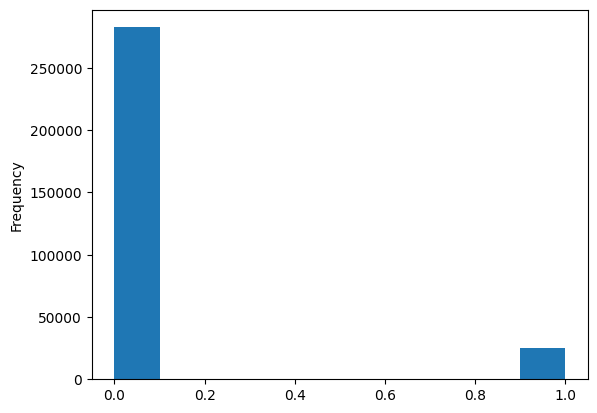

In [110]:
print(application_train["TARGET"].value_counts())
application_train['TARGET'].astype(int).plot.hist();

as we can see the target is imbalanced <br>
the loans were repaid 282686 and not repaid 24825

but as we are using the Reciver Operating Characterstics Area Under the Curve (ROC AUC) as our evaluation metric we will leave the target as it is for now 

# Examine missing values

We will define a function to calculate missing values so we can use it as many as we need 

In [111]:
def check_missing_values(df):
    # first calculate the total missing values
    total = df.isnull().sum()
    #calculate the percentage of missing values
    percent = 100 * df.isnull().sum()/len(df)
    # create a table with the results
    missing_data_table = pd.concat([total, percent], axis=1)
    # rename the columns
    missing_data_table_renamed = missing_data_table.rename(columns={0 : 'Total missing', 1 : '% of Total'})
    # sort the table by percentage
    missing_data_table_renamed = missing_data_table_renamed[
            missing_data_table_renamed.iloc[:,1] != 0].sort_values(
        '% of Total', ascending=False).round(1)
    
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(missing_data_table_renamed.shape[0]) +
              " columns that have missing values.")     
    return missing_data_table_renamed

In [112]:
missing_data = check_missing_values(application_train)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


In [113]:
missing_data

,Total missing,% of Total
COMMONAREA_AVG,214865,69.9
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


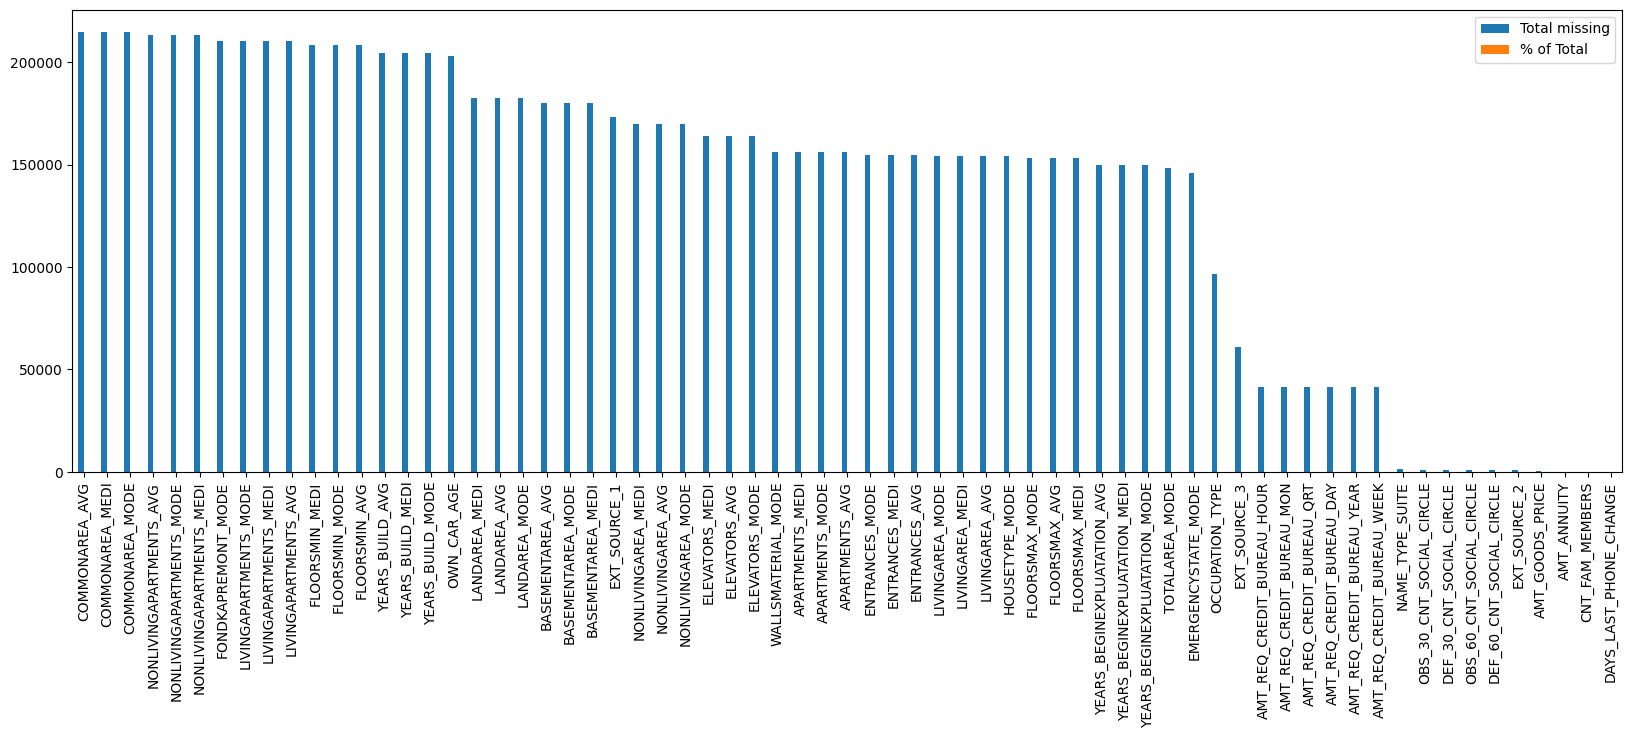

In [114]:
#visualize missing values
missing_data.plot.bar(figsize=(20, 6));

Assess the Impact of Missing Values <br>

Determine the correlation of columns with missing values to the target variabl <br>
Check if columns with missing values are important for prediction <br>

but first we need to deal with the categorical features

# checking the Columns Type

checking the columns type helps us to detrimine numerical and categorical features so we can deal with them

In [115]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

numerical features are easy to work with <br>
so we need to check the categorical features so we can find the best way to handle it 

In [116]:
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

number of unique entries in each column is kind of small so we can  use LabelEncoder or OneHotEncoder to deal with it

For the categorical features with more than 2 unique values we will use OneHotEncoder <br>

For the categorical features with less than 2 unique values we will use LabelEncoder

In [117]:
from sklearn.preprocessing import LabelEncoder

In [118]:
label_encoder = LabelEncoder()
label_encoder_count = 0
for col in application_train:
    if application_train[col].dtype == 'object':
        # if 2 or fewer unique categories use label encoder
        if len(list(application_train[col].unique())) <= 2:
            # fit label encoder
            label_encoder.fit(application_train[col])
            # transform data (test and train)
            application_train[col] = label_encoder.transform(application_train[col])
            application_test[col] = label_encoder.transform(application_test[col])
            # count how many columns were label encoded
            label_encoder_count += 1

print(f"{label_encoder_count} columns were label encoded.")

# one-hot encoding
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

3 columns were label encoded.


In [119]:
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


we need to align the data so we can use it in our model

In [120]:
labels = application_train['TARGET']
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)
application_train['TARGET'] = labels
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


now let us go back to the missing values

let's find the correlation of columns with missing values to the target variabl

In [121]:
# Correlation with target
correlations = application_train.corr()['TARGET'].sort_values()

# Merge missing data with correlation
missing_data = missing_data.merge(correlations, left_index=True, right_index=True, how='left')
print(missing_data)


                          Total missing  % of Total    TARGET
COMMONAREA_AVG                   214865        69.9 -0.018550
COMMONAREA_MEDI                  214865        69.9 -0.018573
COMMONAREA_MODE                  214865        69.9 -0.016340
NONLIVINGAPARTMENTS_AVG          213514        69.4 -0.003176
NONLIVINGAPARTMENTS_MODE         213514        69.4 -0.001557
...                                 ...         ...       ...
EXT_SOURCE_2                        660         0.2 -0.160472
AMT_GOODS_PRICE                     278         0.1 -0.039645
AMT_ANNUITY                          12         0.0 -0.012817
CNT_FAM_MEMBERS                       2         0.0  0.009308
DAYS_LAST_PHONE_CHANGE                1         0.0  0.055218

[67 rows x 3 columns]


In [122]:
# Drop columns with more than 50% missing values and low correlation
drop_columns = missing_data[(missing_data['% of Total'] > 50) & (abs(missing_data['TARGET']) < 0.05)].index
drop_columns

Index(['COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MEDI',
       'FLOORSMIN_MODE', 'FLOORSMIN_AVG', 'YEARS_BUILD_AVG',
       'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'OWN_CAR_AGE', 'LANDAREA_MEDI',
       'LANDAREA_AVG', 'LANDAREA_MODE', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI', 'NONLIVINGAREA_MEDI',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'ELEVATORS_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_MODE',
       'APARTMENTS_AVG', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_AVG',
       'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'LIVINGAREA_AVG'],
      dtype='object')

it's essential to make data-driven decisions regarding whether to drop columns with high missing percentages and weak correlations <br>

1. `COMMONAREA_MEDI`, `COMMONAREA_AVG`, `COMMONAREA_MODE`: These columns represent the common area size of the property. Given that they have high missing percentages and weak correlations with the target, they may not provide significant predictive power.

2. `NONLIVINGAPARTMENTS_MEDI`, `NONLIVINGAPARTMENTS_MODE`, `NONLIVINGAPARTMENTS_AVG`: These columns represent the size of non-living apartments. Similar to the common area columns, they may not be crucial for predicting credit default risk.

3. `LIVINGAPARTMENTS_MODE`, `LIVINGAPARTMENTS_MEDI`, `LIVINGAPARTMENTS_AVG`: These columns represent the size of living apartments. They also have high missing percentages and weak correlations.

4. `FLOORSMIN_MODE`, `FLOORSMIN_MEDI`, `FLOORSMIN_AVG`: These columns represent the minimum number of floors in the building. They may not be highly predictive of credit default risk.

5. `YEARS_BUILD_MODE`, `YEARS_BUILD_MEDI`, `YEARS_BUILD_AVG`: These columns represent the age of the building. While building age might intuitively seem relevant, the high missing percentages and weak correlations suggest they may not significantly impact credit default prediction.

In [123]:
application_train.drop(columns=drop_columns, inplace=True)

In [124]:
missing_data = check_missing_values(application_train)
missing_data

Your selected dataframe has 203 columns.
There are 24 columns that have missing values.


,Total missing,% of Total
EXT_SOURCE_1,173378,56.4
FLOORSMAX_AVG,153020,49.8
FLOORSMAX_MEDI,153020,49.8
FLOORSMAX_MODE,153020,49.8
YEARS_BEGINEXPLUATATION_MEDI,150007,48.8
YEARS_BEGINEXPLUATATION_MODE,150007,48.8
YEARS_BEGINEXPLUATATION_AVG,150007,48.8
TOTALAREA_MODE,148431,48.3
EXT_SOURCE_3,60965,19.8
AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.5


Impute missing values

In [125]:
from sklearn.impute import SimpleImputer

missing_columns =missing_data.index

# Example: Impute missing values for numerical columns
imputer = SimpleImputer(strategy='median')
application_train[missing_columns] = imputer.fit_transform(application_train[missing_columns])



In [126]:
# Check if any missing values remain
missing_values = application_train[missing_columns].isnull().sum()
print("Remaining missing values after imputation:\n", missing_values)

Remaining missing values after imputation:
 EXT_SOURCE_1                    0
FLOORSMAX_AVG                   0
FLOORSMAX_MEDI                  0
FLOORSMAX_MODE                  0
YEARS_BEGINEXPLUATATION_MEDI    0
YEARS_BEGINEXPLUATATION_MODE    0
YEARS_BEGINEXPLUATATION_AVG     0
TOTALAREA_MODE                  0
EXT_SOURCE_3                    0
AMT_REQ_CREDIT_BUREAU_YEAR      0
AMT_REQ_CREDIT_BUREAU_WEEK      0
AMT_REQ_CREDIT_BUREAU_DAY       0
AMT_REQ_CREDIT_BUREAU_QRT       0
AMT_REQ_CREDIT_BUREAU_MON       0
AMT_REQ_CREDIT_BUREAU_HOUR      0
OBS_30_CNT_SOCIAL_CIRCLE        0
OBS_60_CNT_SOCIAL_CIRCLE        0
DEF_30_CNT_SOCIAL_CIRCLE        0
DEF_60_CNT_SOCIAL_CIRCLE        0
EXT_SOURCE_2                    0
AMT_GOODS_PRICE                 0
AMT_ANNUITY                     0
CNT_FAM_MEMBERS                 0
DAYS_LAST_PHONE_CHANGE          0
dtype: int64


looks Great we have no more missing values!

In [127]:
application_test.drop(columns=drop_columns, inplace=True)
application_test[missing_columns] = imputer.transform(application_test[missing_columns])

In [128]:
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 203)
Testing Features shape:  (48744, 202)


let's keep going with the data exploration

## Anomalies

we also need to check if there are any anomalies in the data

In [129]:
# show only the numeric columns
application_train.select_dtypes('number').head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


as we can see the days of birth and days employed has a negative values <br>
this is odd but after understanding the data i realized that they are recorded realative to the current loan application date  

so we can divide the birth by -365 to see the statistics correctly

In [130]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

the age looks reasonable

In [131]:
(application_train['DAYS_EMPLOYED']).describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

i noticed an anomaly as the maximum value is around 365243 days which is 1000 years, which is not realistic.



lets plot the histogram

In [132]:
from matplotlib import pyplot as plt

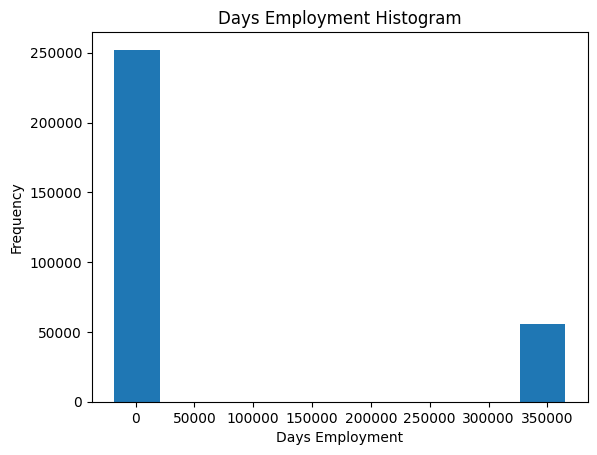

In [133]:
(application_train['DAYS_EMPLOYED']).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

many people have the same strange value of 365243 days.  check if these people are different in some way, like if they are less likely to repay.

In [134]:
anomal = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anomal['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anomal))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


people with the strange value default on loans less than the rest.

mark these strange values as "missing" and add a new column to show which values were strange.

In [135]:
import numpy as np

/tmp/ipykernel_34/3459091069.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


there are 0 anomalies


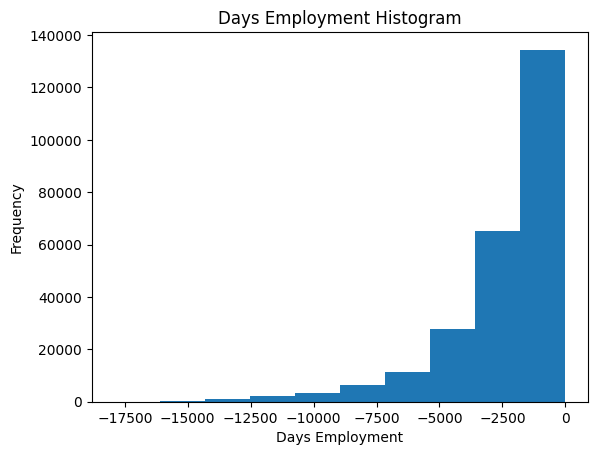

In [148]:
# Mark anomalies
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace strange values with 'nan' (not a number)
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Draw the graph again
application_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
num = application_train["DAYS_EMPLOYED_ANOM"].sum()
print(f"there are {num} anomalies")
plt.xlabel('Days Employment');


our data looks normal again, and we keep track of the strange values.

let us do the same steps to the test data to make sure theya are aligned with the training data

In [153]:
application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

print('There are %d anomalies in the test data out of %d entries' % (application_test["DAYS_EMPLOYED_ANOM"].sum(), len(application_test)))

There are 0 anomalies in the test data out of 48744 entries


/tmp/ipykernel_34/2606311315.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


## Correlation with target

as we dealt with the nulls , categorical and numerical data and anomalies we can now start with seeing correlations between the variables and the target to see the possibile relationships between them

In [154]:
correlations_with_target = application_train.corr()['TARGET'].sort_values()

In [155]:
print('Most Positive Correlations:\n', correlations_with_target.tail(10))
print('\nMost Negative Correlations:\n', correlations_with_target.head(10))

Most Positive Correlations:
 REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
CODE_GENDER_M                  0.054713
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_INCOME_TYPE_Working       0.057481
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
TARGET                         1.000000
DAYS_EMPLOYED_ANOM                  NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_2                           -0.160295
EXT_SOURCE_3                           -0.155892
EXT_SOURCE_1                           -0.098887
DAYS_BIRTH                             -0.078239
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
Name: TARGET, dtype: f

As we see the Days of birth and days employed have the highest positive correlation with the target <br>
and the Exterior sources 2,3 have the highest negative correlation with the target.

let's see the effect of age on the target

In [156]:
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

-0.07823930830982692

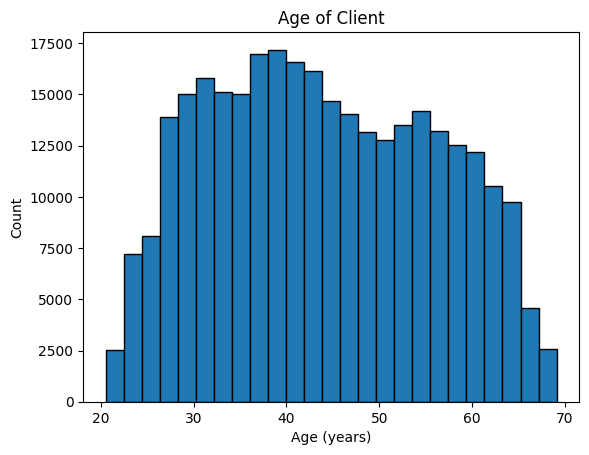

In [157]:
#plot the distribution of ages in years
plt.hist(application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');
plt.show()

As we can see there is a very strong correlation between age and target <br>
whenver the client is older he seems more likely to repay the loan <br>
which actually makes sense for me the older people have more sense of responsibility 

let's see the effect of the Exterior sources on the target

According to the documentation, these features represent a "normalized score from external data source"

let;s see the correlation with the target and with each other 

In [158]:
# Extract the EXT_SOURCE variables and show correlations
ext_source = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_source.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.098887,-0.160295,-0.155892,-0.078239
EXT_SOURCE_1,-0.098887,1.000000,0.134993,0.109100,0.362185
EXT_SOURCE_2,-0.160295,0.134993,1.000000,0.094147,0.091947
EXT_SOURCE_3,-0.155892,0.109100,0.094147,1.000000,0.178527
DAYS_BIRTH,-0.078239,0.362185,0.091947,0.178527,1.000000


In [159]:
import seaborn as sns

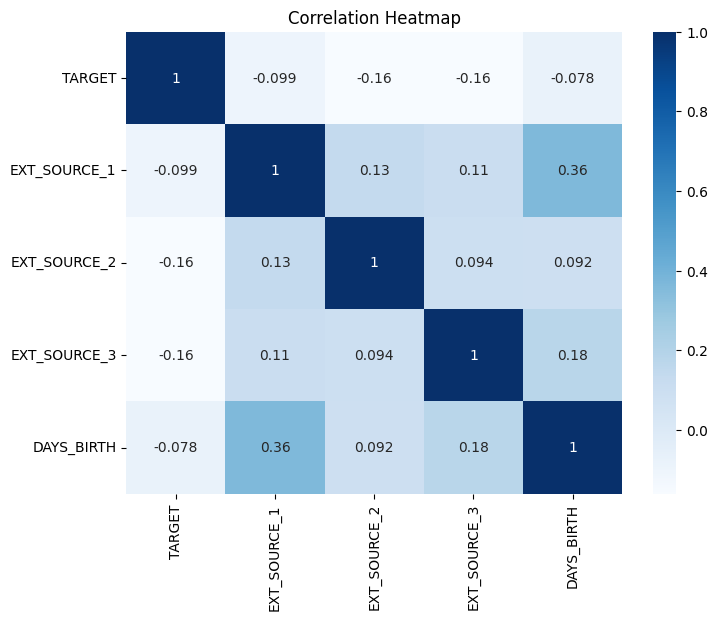

In [160]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = "Blues", annot = True)
plt.title('Correlation Heatmap');

when the Exterior sources are higher the client is more likely to repay the loan

## Feature Engineering Process
**Polynomial Features:** <br>

Create new features based on existing ones by taking powers of existing features and their interactions.<br>
This helps to capture non-linear relationships between features.<br>


**Domain Knowledge Features:**<br>

Create features based on domain knowledge that might help in predicting the target.<br><br><br>
Examples include ratios and percentages that could be significant.<br><br>
**Visualization:**<br>

Visualize the new features to understand their distribution and relationship with the target.


## Polynomial Features Creation: <br>

We will use SimpleImputer to handle missing values.<br>
Use PolynomialFeatures from scikit-learn to create polynomial and interaction features.

In [191]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.impute import SimpleImputer


In [193]:
# Select features for polynomial features
poly_features = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Separate target
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns=['TARGET'])

# Impute missing values and create polynomial features
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=3))
])

poly_features = pipeline.fit_transform(poly_features)
poly_features_test = pipeline.transform(poly_features_test)

# Create dataframe with polynomial features
poly_features = pd.DataFrame(poly_features, columns=pipeline.named_steps['poly'].get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target

In [195]:
# Correlations with target
poly_corrs = poly_features.corr()['TARGET'].sort_values()
poly_corrs

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH     -0.155891
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH     -0.151816
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
EXT_SOURCE_3 DAYS_BIRTH                  -0.150109
EXT_SOURCE_2^2                           -0.149512
EXT_SOURCE_2^2 DAYS_BIRTH                -0.149313
EXT_SOURCE_3^2 DAYS_BIRTH                -0.141777
EXT_SOURCE_3^2                           -0.141662
EXT_SOURCE_2^3                 

In [197]:
# Display most positive and most negative correlations
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [201]:
# Add polynomial features to main dataframes
poly_features['SK_ID_CURR'] = application_train['SK_ID_CURR']
app_train_poly = application_train.merge(poly_features, on='SK_ID_CURR', how='left')

poly_features_test = pd.DataFrame(poly_features_test, columns=pipeline.named_steps['poly'].get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features_test['SK_ID_CURR'] = application_test['SK_ID_CURR']
app_test_poly = application_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

# Align dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join='inner', axis=1)

In [202]:
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 238)
Testing data with polynomial features shape:   (48744, 238)


## Domain Knowledge Features Creation: <br>

Create new features based on domain knowledge such as CREDIT_INCOME_PERCENT, ANNUITY_INCOME_PERCENT, CREDIT_TERM, and DAYS_EMPLOYED_PERCENT.


In [203]:
# Domain knowledge features
domain_features = ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
app_train_domain = application_train.copy()
app_test_domain = application_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']


#### Visualize New Variables


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

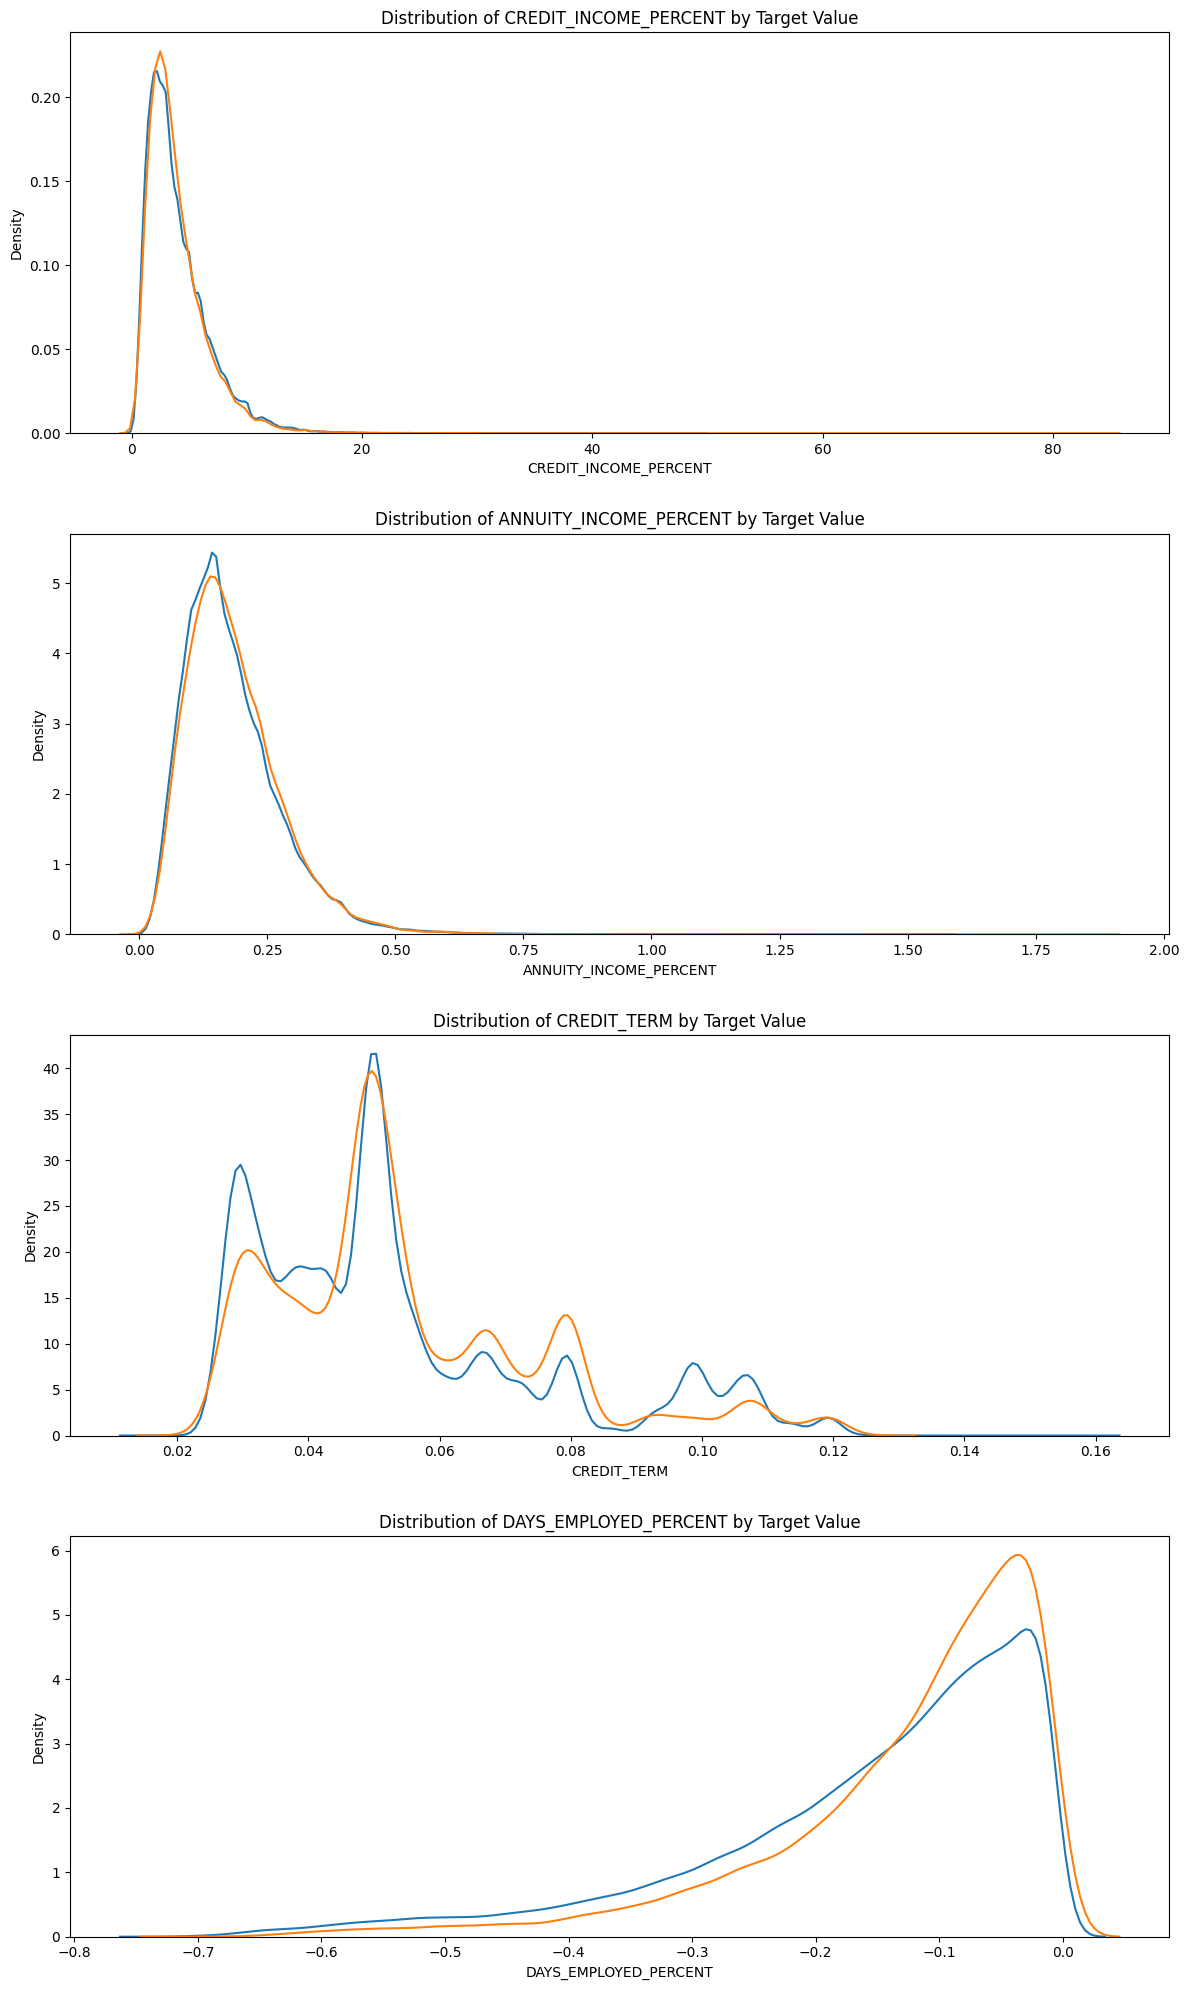

In [204]:
# Visualize new domain knowledge features
plt.figure(figsize=(12, 20))
features_to_plot = ['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label='target == 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label='target == 1')
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')
    
plt.tight_layout(h_pad=2.5)
plt.show()

# Evaluate Model

using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Define features and target
y = application_train['TARGET']
X = application_train.drop(columns=['TARGET'])

# Split the data into training+validation set and test set (80%/20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into training set and validation set (80%/20% of 80%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Create a pipeline with imputation, scaling, and the model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = pipeline.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print(f'Validation AUC: {val_auc}')

Validation AUC: 0.7085516131935521


### Make Predictions using test data

In [208]:
# Evaluate the final model on the test set
test_preds = pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_preds)
print(f'Test AUC: {test_auc}')

Test AUC: 0.7130229275770265


This model scored 0.714 on the test set. 

In [209]:
import pickle

# Save the model to a file
pickle_file = "random_forest_model_main_file.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(model, file)


As so far we only working with the main training file 

let's try working with other datasets to include more information and see what would happen 

First let's use information from bureau and bureau_balance

bureau: information about client's previous loans with other financial
institutions reported to Home Credit. Each previous loan has its own row. <br>
bureau_balance: monthly information about the previous loans. Each month has its own row.

In [210]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [211]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## Counts of a client's previous loans

To demonstrate the manual feature engineering process, let's start with a simple task: counting the number of previous loans for each client at other financial institutions. This involves several Pandas operations that we'll frequently use throughout the notebook:

- `groupby`: grouping a DataFrame by a specific column. Here, we'll group by the unique client identifier, the `SK_ID_CURR` column.
- `agg`: performing calculations on the grouped data, such as taking the mean of columns. We can directly call the function (`grouped_df.mean()`) or use the `agg` function with a list of transformations (`grouped_df.agg([mean, max, min, sum])`).
- `merge`: matching the aggregated statistics to the appropriate client. We'll merge the original training data with the calculated statistics based on the `SK_ID_CURR` column, which will insert `NaN` values for clients without corresponding statistics.

Additionally, we'll frequently use the `rename` function to specify columns to be renamed using a dictionary. This helps us keep track of the new variables we create.

In [214]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [215]:
application_train = application_train.merge(previous_loan_counts, on = 'SK_ID_CURR' , how = "left")
# Fill the missing values with 0 
application_train['previous_loan_counts'] = application_train['previous_loan_counts'].fillna(0)
application_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,previous_loan_counts
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,True,False,True,False,1,False,8.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,True,False,0,False,4.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,0,False,2.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,False,0,False,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,0,False,1.0


## Assessing Variable Utility with r-value

To evaluate the usefulness of a new variable, we use the Pearson Correlation Coefficient (r-value) to measure its relationship with the target. The r-value indicates the strength of a linear relationship between two variables, ranging from -1 to +1. While not a definitive measure, a higher absolute r-value suggests a stronger impact on the target. Therefore, we prioritize variables with the highest absolute r-values. Additionally, we can visually inspect the relationship using Kernel Density Estimate (KDE) plots.


In [266]:
def kde_target(var_name, df):
    """Plots the distribution of a variable colored by the value of the target.

    Parameters:
        var_name (str): The name of the variable to plot.
        df (DataFrame): The DataFrame containing the variable and the target.

    Returns:
        None
    """
    # Calculate the correlation coefficient between the variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    # Plot the distribution for target == 0 and target == 1
    plt.figure(figsize=(12, 6))
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label='TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label='TARGET == 1')
    
    # Label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title(f'{var_name} Distribution')
    plt.legend()
    
    # Print out the correlation and average values
    print(f'The correlation between {var_name} and the TARGET is {corr:.4f}')
    print(f'Median value for loan that was not repaid = {avg_not_repaid:.4f}')
    print(f'Median value for loan that was repaid = {avg_repaid:.4f}')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


The correlation between EXT_SOURCE_3 and the TARGET is -0.1559
Median value for loan that was not repaid = 0.4758
Median value for loan that was repaid = 0.5353


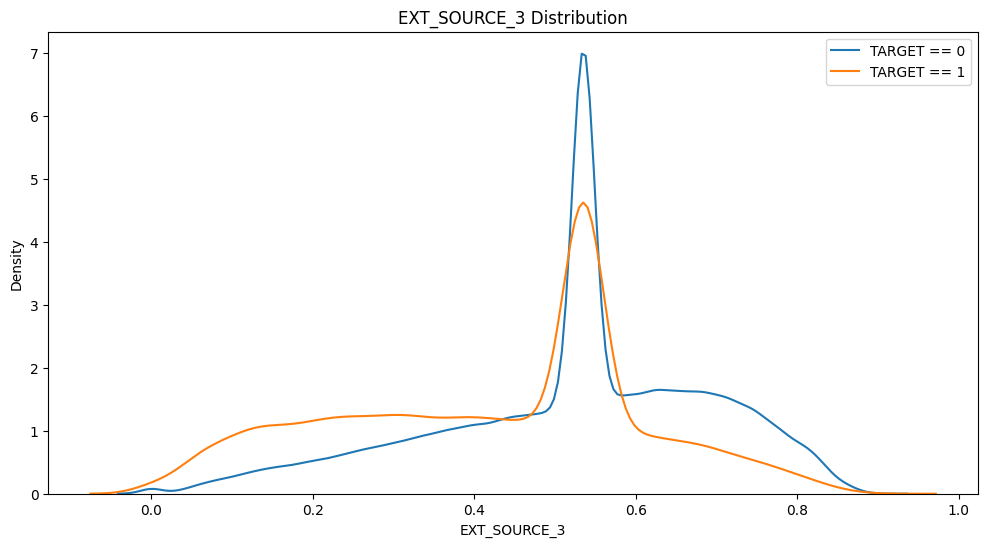

In [219]:
kde_target('EXT_SOURCE_3', application_train)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid = 4.0000


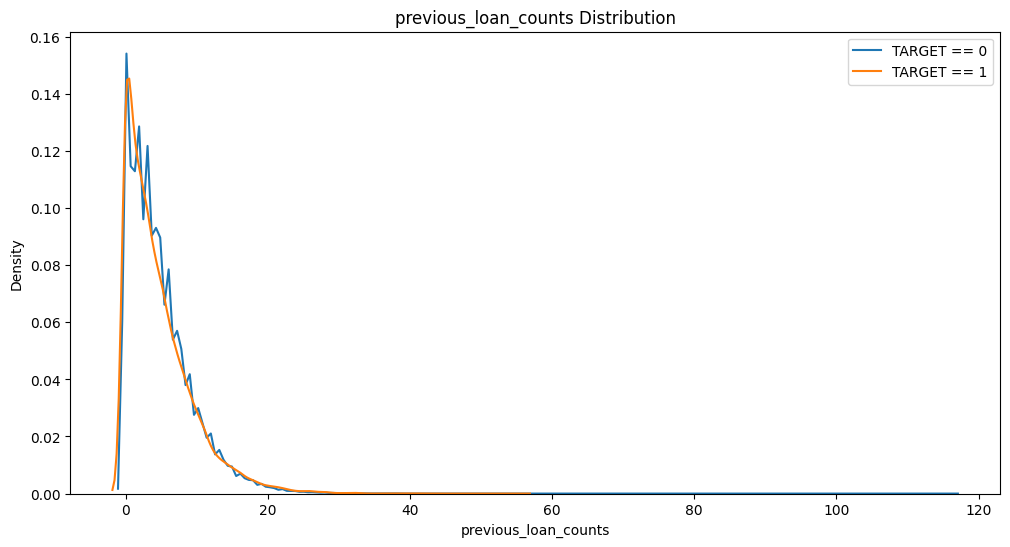

In [220]:
kde_target('previous_loan_counts', application_train)


## Aggregating Numeric Columns

To leverage the numeric information within the `bureau` dataframe, we can compute statistics for all the numeric columns. This involves grouping the data by client id, aggregating the grouped dataframe, and merging the result back into the training data. The `agg` function computes values for numeric columns based on specified operations, such as `'mean', 'max', 'min', 'sum'`. Additionally, custom functions can be applied within the `agg` call to suit specific requirements.


In [ ]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [225]:
bureau_agg_new = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [230]:
# Merge with the training data
application_train = application_train.merge(bureau_agg_new, on = 'SK_ID_CURR', how = 'left')
application_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid = -1067.0000


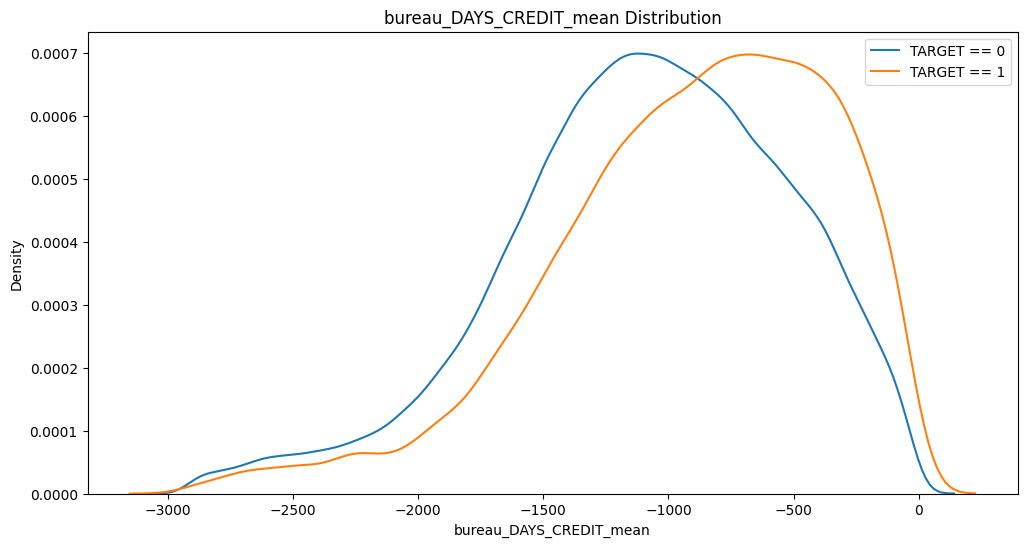

In [234]:
kde_target('bureau_DAYS_CREDIT_mean', application_train)


## Categorical Variables

Now we move from the numeric columns to the categorical columns. These are discrete string variables, so we cannot just calculate statistics such as mean 
and max which only work with numeric variables. Instead, we will rely on calculating value counts of each category within each categorical variable.

In [236]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [237]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [238]:
application_train = application_train.merge(bureau_counts, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
application_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [239]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [240]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [242]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [243]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41,4,0.254545,1.000000,0.0,1.018182


In [244]:
# Merge with the monthly information grouped by client
application_train = application_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

# Evaluating Feature Engineering Results

After all our efforts in feature engineering, it's time to assess the variables we've created. We'll examine:

1. **Missing Values**: Check the percentage of missing values in each variable.
2. **Correlation with Target**: Measure how each variable correlates with the target variable.
3. **Inter-variable Correlation**: Assess correlations between variables to identify redundant ones, known as collinear variables.


In [246]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
          """
    Function to calculate missing values by column.
    
    Parameters:
    - df (DataFrame): Input DataFrame
    
    Returns:
    - DataFrame: Table with columns showing missing values and their percentages
    """
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [247]:
missing_train = missing_values_table(application_train)
missing_train.head(10)

Your selected dataframe has 416 columns.
There are 212 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_MONTHS_BALANCE_min_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_min_count,215280,70.0
client_bureau_balance_STATUS_0_count_norm_count,215280,70.0
client_bureau_balance_STATUS_0_count_sum,215280,70.0
client_bureau_balance_STATUS_0_count_min,215280,70.0
client_bureau_balance_STATUS_0_count_max,215280,70.0
client_bureau_balance_STATUS_0_count_mean,215280,70.0


We see there are a number of columns with a high percentage of missing values.

Here, to reduce the number of features, we will remove any columns in either the training or the testing data that have greater than 90% missing values.

In [250]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 75])
len(missing_train_vars)

0

## Calculate Information for Testing Data

In [253]:
# Merge with the value counts of bureau
application_test = application_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
application_test = application_test.merge(bureau_agg_new, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
application_test = application_test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [255]:
print("Shape of Training Data" ,application_train.shape )
print('Shape of Testing Data: ', application_test.shape)


Shape of Training Data (307511, 416)
Shape of Testing Data:  (48744, 460)


align the testing and training dataframes

In [257]:
train_labels = application_train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)

application_train['TARGET'] = train_labels

In [259]:
print('Training Data Shape: ', application_train.shape)
print('Testing Data Shape: ', application_test.shape)

Training Data Shape:  (307511, 369)
Testing Data Shape:  (48744, 368)


In [260]:
missing_test = missing_values_table(application_test)
missing_test.head(10)

Your selected dataframe has 368 columns.
There are 166 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_CREDIT_MAX_OVERDUE_min,19659,40.3
bureau_AMT_CREDIT_MAX_OVERDUE_max,19659,40.3
bureau_AMT_CREDIT_MAX_OVERDUE_mean,19659,40.3
bureau_DAYS_ENDDATE_FACT_min,10944,22.5
bureau_DAYS_ENDDATE_FACT_max,10944,22.5
bureau_DAYS_ENDDATE_FACT_mean,10944,22.5
bureau_AMT_CREDIT_SUM_LIMIT_min,10683,21.9
bureau_AMT_CREDIT_SUM_LIMIT_max,10683,21.9
bureau_AMT_CREDIT_SUM_LIMIT_mean,10683,21.9
bureau_AMT_ANNUITY_min,10529,21.6


no columns been removed

## Correlations


find the correlations with the target and sort them

In [261]:
# Calculate all correlations in dataframe
corrs = application_train.corr()

In [262]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
DAYS_EMPLOYED,0.074958
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927
client_bureau_balance_MONTHS_BALANCE_sum_min,0.068072


In [263]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
NAME_EDUCATION_TYPE_Higher education,-0.056593
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
DAYS_BIRTH,-0.078239
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.098887
EXT_SOURCE_3,-0.155892
EXT_SOURCE_2,-0.160295


### Collinear Variables


In [269]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [270]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  98


In [271]:
train_corrs_removed = application_train.drop(columns = cols_to_remove)
test_corrs_removed = application_test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 271)
Testing Corrs Removed Shape:  (48744, 270)


In [288]:
print('Training Data Shape: ', application_train.shape)
print('Testing Data Shape: ', application_test.shape)

Training Data Shape:  (307511, 369)
Testing Data Shape:  (48744, 368)


In [272]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

In [289]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Define features and target
y = application_train['TARGET']
X = application_train.drop(columns=['TARGET'])

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with imputation, scaling, and the model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = pipeline.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print(f'Validation AUC: {val_auc}')


Validation AUC: 0.7144101704271857


In [291]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Define features and target
y = train_corrs_removed['TARGET']
X = train_corrs_removed.drop(columns=['TARGET'])

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with imputation, scaling, and the model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = pipeline.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print(f'Validation AUC: {val_auc}')


Validation AUC: 0.716818326289471


let's try get more info from the rest of the datasets

## Function to Aggregate Numeric Data

This groups data by the `group_var` and calculates `mean`, `max`, `min`, and `sum`. It will only be applied to numeric data by default in pandas.

In [316]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

### Function to Calculate Categorical Counts

This function calculates the occurrences (counts) of each category in a categorical variable for each client. It also calculates the normed count, which is the count for a category divided by the total counts for all categories in a categorical variable. 

In [317]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

# Function to Convert Data Types

This will help reduce memory usage by using more efficient types for the variables. For example `category` is often a better type than `object` (unless the number of unique categories is close to the number of rows in the dataframe).

In [318]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [293]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


### previous_application

In [301]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous_application, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 101)


,SK_ID_CURR,previous_SK_ID_PREV_count,previous_SK_ID_PREV_mean,previous_SK_ID_PREV_max,previous_SK_ID_PREV_min,previous_SK_ID_PREV_sum,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,1.369693e+06,1369693,1369693,1369693,1,3951.000,3951.000,3951.000,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,1.038818e+06,1038818,1038818,1038818,1,9251.775,9251.775,9251.775,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,2.281150e+06,2636178,1810518,6843451,3,56553.990,98356.995,6737.310,...,3,-1047.333333,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,1.564014e+06,1564014,1564014,1564014,1,5357.250,5357.250,5357.250,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,2,2.176837e+06,2495675,1857999,4353674,1,4813.200,4813.200,4813.200,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [304]:
# Merge in the previous information
application_train = application_train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

application_test = application_test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous_application, previous_agg
gc.collect()

10606

In [305]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [307]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [308]:
application_train, application_test = remove_missing_columns(application_train, application_test)


There are 12 columns with greater than 90% missing values.


### Function to Aggregate Stats at the Client Level

In [309]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

## Monthly Cash Data

In [310]:
POS_CASH_balance = convert_types(POS_CASH_balance, print_info=True)
POS_CASH_balance.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [320]:
cash_by_client = aggregate_client(POS_CASH_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28.0,32,36.0,36.000000,36.0,41,41,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,456.0,361,456.0,456.000000,456.0,361,361,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,288.0,256,248.0,283.000000,288.0,272,272,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,16.0,12,12.0,15.000000,16.0,16,16,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,132.0,99,99.0,128.699997,132.0,110,110,121,792.0,1287.0


## Monthly Credit Data

In [314]:
credit = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [319]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432373,4843.063965,4843.063965,4843.063965,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346191,7168.346191,7168.346191,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Installment Payments

In [321]:
installments_payments = convert_types(installments_payments, print_info = True)
installments_payments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.44 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [322]:
installments_by_client = aggregate_client(installments_payments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


In [323]:
print('Final Training Shape: ', application_train.shape)
print('Final Testing Shape: ', application_test.shape)

Final Training Shape:  (307511, 557)
Final Testing Shape:  (48744, 556)


 #### Save All Newly Calculated Features


In [324]:
application_train.to_csv('train_previous_raw.csv', index = False, chunksize = 500)
application_test.to_csv('test_previous_raw.csv', index = False)

In [325]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# Feature Selection

 that aims to select the top k features from a given feature matrix X based on the chi-squared test.

In [332]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

def select_features(X, y, k=10):
    """
    Select top k features using chi-squared test.
    
    Parameters:
        X (DataFrame): Feature matrix.
        y (Series): Target variable.
        k (int): Number of top features to select (default=10).
    
    Returns:
        X_new (DataFrame): Transformed feature matrix with selected features.
    """
    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    
    # Scale features to the range [0, 1]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # Initialize SelectKBest object
    selector = SelectKBest(score_func=chi2, k=k)
    
    # Fit and transform feature matrix
    X_new = selector.fit_transform(X_scaled, y)
    
    # Get selected feature indices
    selected_features = selector.get_support(indices=True)
    
    # Get column names of selected features
    selected_feature_names = X.columns[selected_features]
    
    print(f"Selected Features: {selected_feature_names}")
    
    return X_new


In [333]:
# Define features and target
y = application_train['TARGET']
X = application_train.drop(columns=['TARGET'])

# Perform feature selection
X_selected = select_features(X, y, k=10)

Selected Features: Index(['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'OCCUPATION_TYPE_Laborers', 'ORGANIZATION_TYPE_XNA'],
      dtype='object')


In [334]:
# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a pipeline with imputation, scaling, and the model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = pipeline.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print(f'Validation AUC: {val_auc}')


Validation AUC: 0.6293657841367885


as we can see the best model was the one when we used the train_bureau_corrs_removed with auc 71% (trained_model_final)

and this is the one that we will use to deploy our model

# Some Further Insights

# Derive business insights
# Here are some potential insights you can derive:

# 1. Identify high-risk applicants: 
#    Sort the test predictions and identify applicants with high probabilities of default.


In [ ]:
high_risk_applicants = application_test.loc[test_preds > 0.5]
print("High-risk Applicants:")
print(high_risk_applicants)

High-risk Applicants:
       SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
20653      249801                   0             0                1   
27381      299847                   0             1                1   
36317      365859                   0             1                1   
45126      430473                   0             0                1   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
20653             0           87358.5    389844.0      16735.5   
27381             0          130500.0    481176.0      24696.0   
36317             2          112500.0    481176.0      26230.5   
45126             3          202500.0    156384.0      17815.5   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  ...  \
20653         315000.0                    0.015221  ...   
27381         360000.0                    0.019101  ...   
36317         360000.0                    0.018850  ...   
45126         135000.0                    0.010147

# Insights and Business Meaning: <br>
## High-Risk Applicants:<br>

These are individuals who are predicted to have a high likelihood of defaulting on their loans.<br>
For instance, the first applicant (SK_ID_CURR = 249801) has various characteristics that contribute to the model's prediction of them being high-risk.<br>

Loan Approval Strategy:<br>

Financial institutions can use this information to make more informed decisions regarding loan approvals. High-risk applicants may need additional scrutiny, collateral, or higher interest rates to mitigate potential losses.<br>

Personalized Interventions:<br>

High-risk applicants could be targeted for financial counseling or offered alternative financial products tailored to reduce their default risk.<br>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


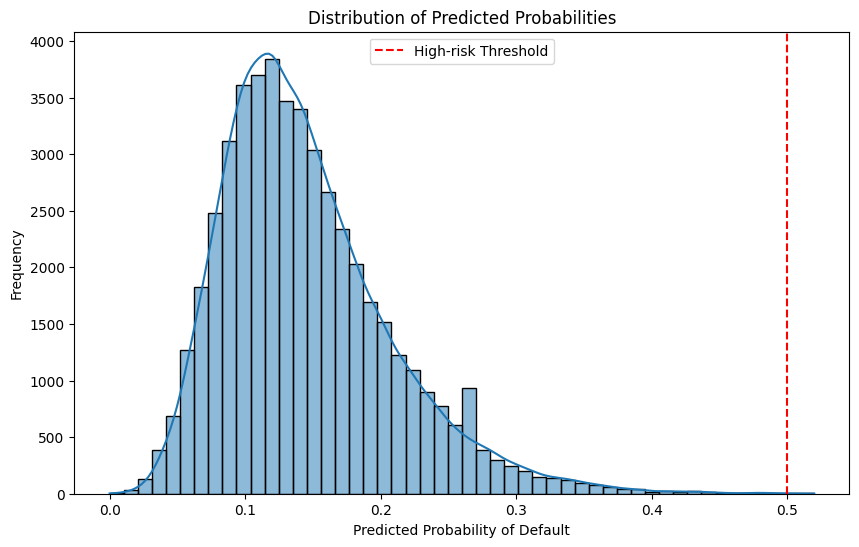

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# High-risk Applicants Distribution
plt.figure(figsize=(10, 6))
sns.histplot(test_preds, bins=50, kde=True)
plt.axvline(x=0.5, color='r', linestyle='--', label='High-risk Threshold')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 2. Analyze feature importances:
#    Determine which features are most influential in predicting loan default.

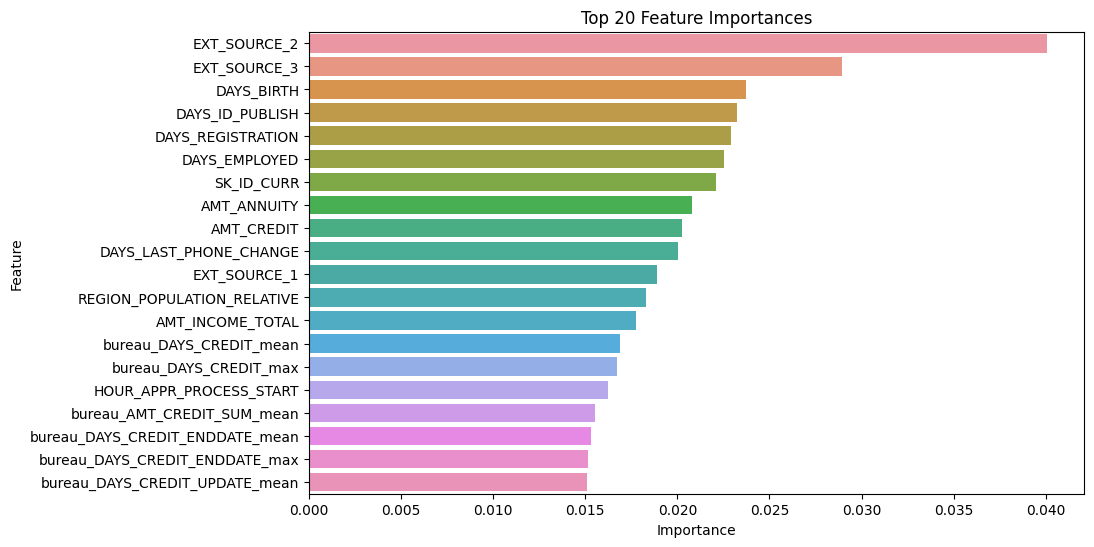

In [ ]:
# Feature Importances
importances_df = pd.DataFrame(sorted_importances, columns=['Importance', 'Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))  # Plot top 20 features
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 3. Customer segmentation:
#    Segment applicants based on predicted probabilities into low, medium, and high-risk categories.

In [ ]:
application_test['Predicted_Probability'] = test_preds
low_risk = application_test.loc[test_preds < 0.25]
medium_risk = application_test.loc[(test_preds >= 0.25) & (test_preds < 0.75)]
high_risk = application_test.loc[test_preds >= 0.75]

print("Low-risk Applicants:")
print(low_risk)
print("Medium-risk Applicants:")
print(medium_risk)
print("High-risk Applicants:")
print(high_risk)

Low-risk Applicants:
       SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0          100001                   0             0                1   
1          100005                   0             0                1   
2          100013                   0             1                1   
3          100028                   0             0                1   
4          100038                   0             1                0   
...           ...                 ...           ...              ...   
48739      456221                   0             0                1   
48740      456222                   0             0                0   
48741      456223                   0             1                1   
48742      456224                   0             0                0   
48743      456250                   0             1                0   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.

# Business Insights: <br>
## Low-risk Applicants:<br>

These are individuals with a low likelihood of defaulting on their loans. They are typically safer to approve for loans.<br>
For example, the first applicant (SK_ID_CURR = 100001) has characteristics that the model has determined to be low risk.<br>

## Medium-risk Applicants:<br>

These applicants have a moderate likelihood of default. They might need closer evaluation and potentially stricter loan terms to mitigate risk.<br>
They are not shown in the provided output snippet but can be reviewed similarly.<br>

## High-risk Applicants:<br>
<br>
These are individuals with a high likelihood of default. Loans to these applicants should be considered very carefully, possibly requiring higher interest rates, more collateral, or even rejection of the loan application.<br>
The detailed output for high-risk applicants can be seen in the earlier response.<br>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


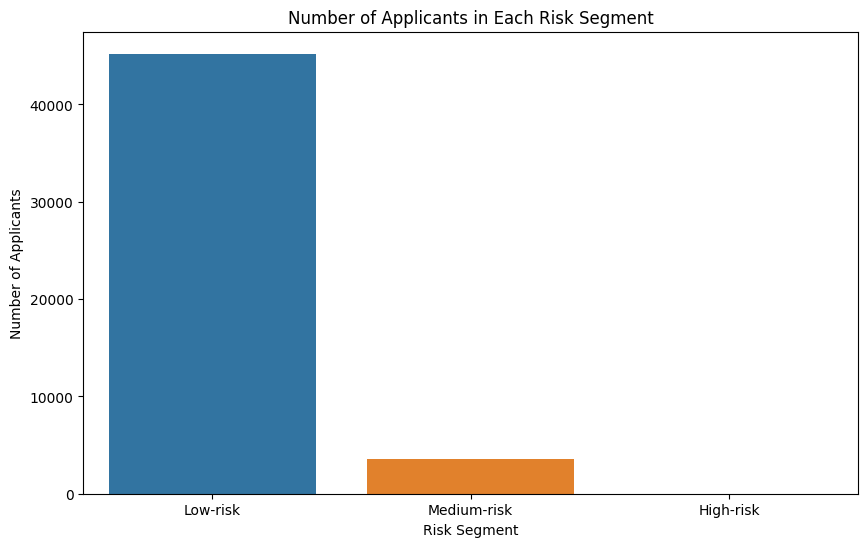

In [ ]:
# Customer Segmentation
segments = {
    'Low-risk': low_risk,
    'Medium-risk': medium_risk,
    'High-risk': high_risk
}

# Count of Applicants in Each Risk Segment
segment_counts = {k: len(v) for k, v in segments.items()}
plt.figure(figsize=(10, 6))
sns.barplot(x=list(segment_counts.keys()), y=list(segment_counts.values()))
plt.title('Number of Applicants in Each Risk Segment')
plt.xlabel('Risk Segment')
plt.ylabel('Number of Applicants')
plt.show()

# References

<a> kaggle notebook : https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search#Random-Search </a> <br>
<a> https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest </a> <br>
<a> openAI </a> <br>
<a> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html </a> <br>
<a> Youtube: https://youtu.be/moxJjdE_t00?si=2ytP1uljVL1YY0qE </a>

 # **Deployement** 

Deploying a machine learning model into a production environment involves several steps to ensure its reliability, scalability, and efficiency.

1. **Define Objectives and Requirements**
2. **Select Deployment Infrastructure**
3. **Model Serialization**

4. **Integration with Application**
5. **Scalability and Performance Optimization**
6. **Monitoring and Logging**
7. **Security and Compliance**
8. **Testing and Quality Assurance**
9. **Continuous Integration and Deployment (CI/CD)**e code changes and track model versions.

10. **Documentation and Training**
11. **Feedback and Iteration**
12. **Disaster Recovery and Backup**